# Introduction:

**Data Preprocessing:**
- Handling Missing Values: Replacing missing values with the median of their respective columns ensures that the dataset is complete and suitable for analysis.
- Outlier Removal: Removing outliers and negative weekly sales helps in maintaining data integrity and ensuring that the models are trained on meaningful data.

**Machine Learning Algorithms using Spark MLib:**
- Model Selection: Use Spark MLlib to train machine learning algorithms like Linear Regression, Random Forest, KNN, and XGBoost Regression models.
- Evaluation Metrics: Assessing the accuracy of each model using appropriate evaluation metrics, such as mean absolute error or root mean squared error, will aid in selecting the best-performing algorithm.

**Expected Outcome:**
- Robust Predictive Model: The main goal is to develop a predictive model capable of accurately forecasting department-wide sales for each Walmart store. This model should leverage the features provided in the dataset, such as store type, size, promotional markdowns, and holiday weeks.
- Analysis of Impact: Analyzing the impact of promotional markdowns and holiday weeks on sales will provide valuable insights into the effectiveness of these strategies. Identifying key features influencing sales will aid in understanding the factors driving sales performance and inform future sales strategies

# **Importing Modules**

Setting up Spark environment using PySpark, installing OpenJDK 8, downloaded Apache Spark version 3.3.0, and initialized Spark using findspark.

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.3.0/spark-3.3.0-bin-hadoop3.tgz
!tar xf spark-3.3.0-bin-hadoop3.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.3.0-bin-hadoop3"

In [3]:
import findspark
findspark.init()

In [4]:
findspark.find()

'spark-3.3.0-bin-hadoop3'

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum,col
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

## Importing Pyspark libraries

In [46]:
import pyspark.sql
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql.types import IntegerType
import json
from pyspark.sql.functions import regexp_replace, col
from pyspark.sql.functions import expr
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, split, regexp_extract
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, when, to_timestamp, unix_timestamp
from pyspark.sql import functions as F
from pyspark.sql.functions import avg,hour,lit,to_date
from pyspark.sql.functions import desc
from pyspark.ml.feature import StandardScaler
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col, max, min, mean, stddev_samp, expr
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import year, month, weekofyear

## Importing Python Libaries

In [17]:
import pickle
import os
from os import path
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from scipy import stats
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

You may need to restart the session  after installing the scikeras library

In [8]:
# Installing scikeras Library
!pip install scikeras
from scikeras.wrappers import KerasRegressor, KerasClassifier

# **Importing Datasets**

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# Reading the CSV files into Spark DataFrames
data = spark.read.csv('/content/drive/MyDrive/Cloud Computing Project Datasets/train.csv', header=True, inferSchema=True)
stores = spark.read.csv('/content/drive/MyDrive/Cloud Computing Project Datasets/stores.csv', header=True, inferSchema=True)
features = spark.read.csv('/content/drive/MyDrive/Cloud Computing Project Datasets/features.csv', header=True, inferSchema=True)

In [11]:
# @title Exploring Dataframe
num_rows = data.count()
num_columns = len(data.columns)
print("Shape of the DataFrame: ({}, {})".format(num_rows, num_columns))

Shape of the DataFrame: (421570, 5)


In [12]:
# Sorting the DataFrame by the 'Store' column in descending order
sorted_data = data.orderBy(desc("Store"))
tail_data = sorted_data.limit(5)  # Get the last 5 rows
tail_data.show()


+-----+----+-------------------+------------+---------+
|Store|Dept|               Date|Weekly_Sales|IsHoliday|
+-----+----+-------------------+------------+---------+
|   45|   1|2010-02-05 00:00:00|    18628.11|    false|
|   45|   1|2010-02-26 00:00:00|    14656.08|    false|
|   45|   1|2010-03-05 00:00:00|    16608.87|    false|
|   45|   1|2010-02-12 00:00:00|    22416.94|     true|
|   45|   1|2010-02-19 00:00:00|    28756.53|    false|
+-----+----+-------------------+------------+---------+



In [13]:
# Display the schema of the DataFrame
data.printSchema()

root
 |-- Store: integer (nullable = true)
 |-- Dept: integer (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Weekly_Sales: double (nullable = true)
 |-- IsHoliday: boolean (nullable = true)



In [14]:
print("Summary Statistics for Data:")
data.describe().show()

Summary Statistics for Data:
+-------+------------------+-----------------+------------------+
|summary|             Store|             Dept|      Weekly_Sales|
+-------+------------------+-----------------+------------------+
|  count|            421570|           421570|            421570|
|   mean|22.200545579619043|44.26031738501317|15981.258123467178|
| stddev|12.785297389902839|30.49205401578581|22711.183519163176|
|    min|                 1|                1|          -4988.94|
|    max|                45|               99|         693099.36|
+-------+------------------+-----------------+------------------+



In [15]:
# Checking for the missing values in each column
missing_values = data.select([F.sum(F.col(c).isNull().cast('int')).alias(c) for c in data.columns])
missing_values.show()

+-----+----+----+------------+---------+
|Store|Dept|Date|Weekly_Sales|IsHoliday|
+-----+----+----+------------+---------+
|    0|   0|   0|           0|        0|
+-----+----+----+------------+---------+



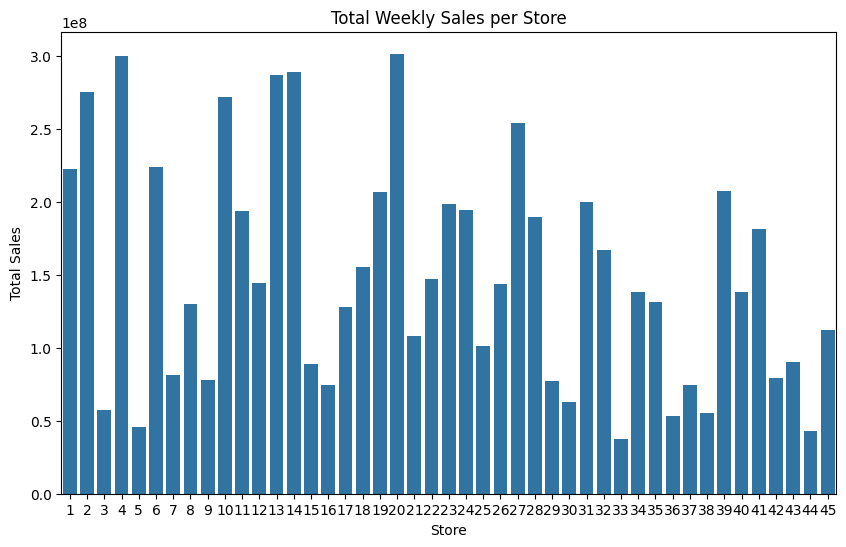

In [18]:
# total weekly sales for each store
total_sales_per_store = data.groupBy('Store').agg(F.sum('Weekly_Sales').alias('Total_Sales'))

# Plotting the total weekly sales per store
sales_data = total_sales_per_store.collect()
sales_df = spark.createDataFrame(sales_data).toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x='Store', y='Total_Sales', data=sales_df)
plt.title('Total Weekly Sales per Store')
plt.xlabel('Store')
plt.ylabel('Total Sales')
plt.show()


In [19]:
# @title Shape of the Store Dataset
num_rows = stores.count()
num_cols = len(stores.columns)

print("Number of rows:", num_rows)
print("Number of columns:", num_cols)

Number of rows: 45
Number of columns: 3


In [20]:
# Display last few rows of stores
stores.orderBy(stores.columns[-1], ascending=False).show(5)

+-----+----+------+
|Store|Type|  Size|
+-----+----+------+
|   13|   A|219622|
|   11|   A|207499|
|   28|   A|206302|
|    4|   A|205863|
|   27|   A|204184|
+-----+----+------+
only showing top 5 rows



In [21]:
# Print the schema of the stores DataFrame
stores.printSchema()

# Count the number of rows in the DataFrame
print("Number of rows: ", stores.count())

# Summarize missing values in each column
for col in stores.columns:
    print("Missing values in column", col, ": ", stores.filter(stores[col].isNull()).count())


root
 |-- Store: integer (nullable = true)
 |-- Type: string (nullable = true)
 |-- Size: integer (nullable = true)

Number of rows:  45
Missing values in column Store :  0
Missing values in column Type :  0
Missing values in column Size :  0


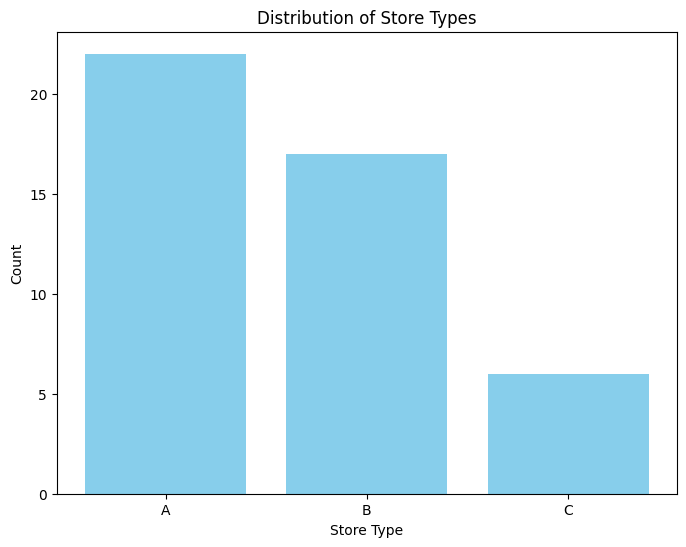

In [22]:
# Group by store type and count the occurrences of each type
type_counts = stores.groupBy('Type').count().orderBy('Type')
type_counts_pd = type_counts.toPandas()

# Plotting the distribution of store types
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.bar(type_counts_pd['Type'], type_counts_pd['count'], color='skyblue')
plt.title('Distribution of Store Types')
plt.xlabel('Store Type')
plt.ylabel('Count')
plt.show()



In [23]:
# @title Dataset containing additional data of Stores and the shape of the dataset
num_rows = features.count()
num_cols = len(features.columns)
print("Number of rows: ", num_rows)
print("Number of columns: ", num_cols)

Number of rows:  8190
Number of columns:  12


In [24]:
# Show the last few rows of the features DataFrame
features_tail = features.orderBy(features.columns[0], ascending=False).limit(5)
print("Last few rows:")
features_tail.show()


Last few rows:
+-----+-------------------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+---------+
|Store|               Date|Temperature|Fuel_Price|MarkDown1|MarkDown2|MarkDown3|MarkDown4|MarkDown5|        CPI|Unemployment|IsHoliday|
+-----+-------------------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+---------+
|   45|2010-02-05 00:00:00|      27.31|     2.784|       NA|       NA|       NA|       NA|       NA|181.8711898|       8.992|    false|
|   45|2010-03-05 00:00:00|      37.13|     2.777|       NA|       NA|       NA|       NA|       NA|182.1201566|       8.992|    false|
|   45|2010-02-12 00:00:00|      27.73|     2.773|       NA|       NA|       NA|       NA|       NA| 181.982317|       8.992|     true|
|   45|2010-02-19 00:00:00|      31.27|     2.745|       NA|       NA|       NA|       NA|       NA|182.0347816|       8.992|    false|
|   45|2010-02-26 00:00:00|      

In [25]:
print("Features Schema:")
features.printSchema()
print("Number of rows: ", features.count())

# Summarize missing values in each column
print("Missing values summary:")
missing_summary = features.agg(*[
    (1 - (F.count(c) / num_rows)).alias(c + '_missing')
    for c in features.columns
])
missing_summary.show()


Features Schema:
root
 |-- Store: integer (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Fuel_Price: double (nullable = true)
 |-- MarkDown1: string (nullable = true)
 |-- MarkDown2: string (nullable = true)
 |-- MarkDown3: string (nullable = true)
 |-- MarkDown4: string (nullable = true)
 |-- MarkDown5: string (nullable = true)
 |-- CPI: string (nullable = true)
 |-- Unemployment: string (nullable = true)
 |-- IsHoliday: boolean (nullable = true)

Number of rows:  8190
Missing values summary:
+-------------+------------+-------------------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------+--------------------+-----------------+
|Store_missing|Date_missing|Temperature_missing|Fuel_Price_missing|MarkDown1_missing|MarkDown2_missing|MarkDown3_missing|MarkDown4_missing|MarkDown5_missing|CPI_missing|Unemployment_missing|IsHoliday_missing|
+-------------+----------

In [28]:
# Convert string columns to double type
string_columns = ["MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5", "CPI", "Unemployment"]
for col_name in string_columns:
    features = features.withColumn(col_name, col(col_name).cast(DoubleType()))

# Verify the schema after conversion
print("Updated Features Schema:")
features.printSchema()


Updated Features Schema:
root
 |-- Store: integer (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Fuel_Price: double (nullable = true)
 |-- MarkDown1: double (nullable = true)
 |-- MarkDown2: double (nullable = true)
 |-- MarkDown3: double (nullable = true)
 |-- MarkDown4: double (nullable = true)
 |-- MarkDown5: double (nullable = true)
 |-- CPI: double (nullable = true)
 |-- Unemployment: double (nullable = true)
 |-- IsHoliday: boolean (nullable = true)



# **Data Preprocessing**

##  Handling missing values of features dataset

 Filling missing values in the CPI and Unemployment columns with the median values for handling missing data. This code calculates the median values for the CPI and Unemployment columns using the percentile_approx function and then fills the missing values in the respective columns using the na.fill function.

In [29]:
# Calculate the median values for CPI and Unemployment columns
cpi_median = features.selectExpr("percentile_approx(CPI, 0.5)").collect()[0][0]
unemployment_median = features.selectExpr("percentile_approx(Unemployment, 0.5)").collect()[0][0]

# Fill missing values in the CPI & Unemployment column with the median
features = features.na.fill(cpi_median, subset=["CPI"])
features = features.na.fill(unemployment_median, subset=["Unemployment"])


In [30]:
# if the values in the markdown have negative values, We are replacing them with zero
for i in range(1, 6):
    features = features.withColumn("MarkDown"+str(i), when(col("MarkDown"+str(i)) < 0, 0).otherwise(col("MarkDown"+str(i))))
    features = features.fillna({ "MarkDown"+str(i): 0 })

In [31]:
features.printSchema()

root
 |-- Store: integer (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Fuel_Price: double (nullable = true)
 |-- MarkDown1: double (nullable = false)
 |-- MarkDown2: double (nullable = false)
 |-- MarkDown3: double (nullable = false)
 |-- MarkDown4: double (nullable = false)
 |-- MarkDown5: double (nullable = false)
 |-- CPI: double (nullable = false)
 |-- Unemployment: double (nullable = false)
 |-- IsHoliday: boolean (nullable = true)



In [32]:
# Calculate the total markdown and add it as a new column
features = features.withColumn("Total_MarkDown", col("MarkDown1") + col("MarkDown2") + col("MarkDown3") + col("MarkDown4") + col("MarkDown5"))
features = features.drop("MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5")

features.printSchema()


root
 |-- Store: integer (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Fuel_Price: double (nullable = true)
 |-- CPI: double (nullable = false)
 |-- Unemployment: double (nullable = false)
 |-- IsHoliday: boolean (nullable = true)
 |-- Total_MarkDown: double (nullable = false)



## Merging Training Dataset and merged stores-features Dataset

This code joins the data DataFrame with the stores DataFrame based on the "Store" column, similar to the pd.merge operation in pandas. The resulting DataFrame data will contain columns from both DataFrames. Finally, it prints the schema of the merged DataFrame to verify the changes.

In [33]:
data = data.join(stores, on='Store', how='left')
data.printSchema()

root
 |-- Store: integer (nullable = true)
 |-- Dept: integer (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Weekly_Sales: double (nullable = true)
 |-- IsHoliday: boolean (nullable = true)
 |-- Type: string (nullable = true)
 |-- Size: integer (nullable = true)



In [34]:
data.show(5)

+-----+----+-------------------+------------+---------+----+------+
|Store|Dept|               Date|Weekly_Sales|IsHoliday|Type|  Size|
+-----+----+-------------------+------------+---------+----+------+
|    1|   1|2010-02-05 00:00:00|     24924.5|    false|   A|151315|
|    1|   1|2010-02-12 00:00:00|    46039.49|     true|   A|151315|
|    1|   1|2010-02-19 00:00:00|    41595.55|    false|   A|151315|
|    1|   1|2010-02-26 00:00:00|    19403.54|    false|   A|151315|
|    1|   1|2010-03-05 00:00:00|     21827.9|    false|   A|151315|
+-----+----+-------------------+------------+---------+----+------+
only showing top 5 rows



In [35]:
# Renaming the IsHoliday column to IsHoliday_x for the dataset 'data' to make it seperate from IsHoliday column for the 'Store' Dataset

data = data.withColumnRenamed('IsHoliday', 'IsHoliday_x')

In [36]:
data.show(5)

+-----+----+-------------------+------------+-----------+----+------+
|Store|Dept|               Date|Weekly_Sales|IsHoliday_x|Type|  Size|
+-----+----+-------------------+------------+-----------+----+------+
|    1|   1|2010-02-05 00:00:00|     24924.5|      false|   A|151315|
|    1|   1|2010-02-12 00:00:00|    46039.49|       true|   A|151315|
|    1|   1|2010-02-19 00:00:00|    41595.55|      false|   A|151315|
|    1|   1|2010-02-26 00:00:00|    19403.54|      false|   A|151315|
|    1|   1|2010-03-05 00:00:00|     21827.9|      false|   A|151315|
+-----+----+-------------------+------------+-----------+----+------+
only showing top 5 rows



In [37]:
# Joining the data DataFrame with the features DataFrame
data = data.join(features, on=['Store', 'Date'], how='left')

In [38]:
# Verifying the schema
data.show(5)

+-----+-------------------+----+------------+-----------+----+------+-----------+----------+-----------+------------+---------+--------------+
|Store|               Date|Dept|Weekly_Sales|IsHoliday_x|Type|  Size|Temperature|Fuel_Price|        CPI|Unemployment|IsHoliday|Total_MarkDown|
+-----+-------------------+----+------------+-----------+----+------+-----------+----------+-----------+------------+---------+--------------+
|    1|2010-02-05 00:00:00|   1|     24924.5|      false|   A|151315|      42.31|     2.572|211.0963582|       8.106|    false|           0.0|
|    1|2010-02-12 00:00:00|   1|    46039.49|       true|   A|151315|      38.51|     2.548|211.2421698|       8.106|     true|           0.0|
|    1|2010-02-19 00:00:00|   1|    41595.55|      false|   A|151315|      39.93|     2.514|211.2891429|       8.106|    false|           0.0|
|    1|2010-02-26 00:00:00|   1|    19403.54|      false|   A|151315|      46.63|     2.561|211.3196429|       8.106|    false|           0.0|

In [39]:
#converting 'date' column to date type
data = data.withColumn("Date", to_date(data["Date"]))
data.printSchema()

root
 |-- Store: integer (nullable = true)
 |-- Date: date (nullable = true)
 |-- Dept: integer (nullable = true)
 |-- Weekly_Sales: double (nullable = true)
 |-- IsHoliday_x: boolean (nullable = true)
 |-- Type: string (nullable = true)
 |-- Size: integer (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Fuel_Price: double (nullable = true)
 |-- CPI: double (nullable = true)
 |-- Unemployment: double (nullable = true)
 |-- IsHoliday: boolean (nullable = true)
 |-- Total_MarkDown: double (nullable = true)



In [40]:
# Sorting the data in the descending order of 'date'
data = data.orderBy(col('Date'))
data = data.orderBy(desc('Date'))

data.show(5)

+-----+----------+----+------------+-----------+----+-----+-----------+----------+-----------+------------+---------+--------------+
|Store|      Date|Dept|Weekly_Sales|IsHoliday_x|Type| Size|Temperature|Fuel_Price|        CPI|Unemployment|IsHoliday|Total_MarkDown|
+-----+----------+----+------------+-----------+----+-----+-----------+----------+-----------+------------+---------+--------------+
|   29|2012-10-26|   8|    23498.69|      false|   B|93638|      57.58|     3.917|138.7281613|       9.151|    false|       6379.12|
|   29|2012-10-26|  13|    19051.93|      false|   B|93638|      57.58|     3.917|138.7281613|       9.151|    false|       6379.12|
|   29|2012-10-26|   9|    12002.24|      false|   B|93638|      57.58|     3.917|138.7281613|       9.151|    false|       6379.12|
|   29|2012-10-26|   4|    16512.89|      false|   B|93638|      57.58|     3.917|138.7281613|       9.151|    false|       6379.12|
|   29|2012-10-26|  10|     9292.04|      false|   B|93638|      57.5

In [41]:
# checking whether 'IsHoliday_x' and 'IsHoliday' have similar values for all the entries
all_matched = data.select('IsHoliday_x').subtract(data.select('IsHoliday')).isEmpty()
print(all_matched)


True


In [42]:
#  We have obtained that 'IsHoliday_x' and 'IsHoliday' are similar in the dataset, then we will remove one of them.
data = data.drop('IsHoliday_x')
data.show(5)


+-----+----------+----+------------+----+-----+-----------+----------+-----------+------------+---------+--------------+
|Store|      Date|Dept|Weekly_Sales|Type| Size|Temperature|Fuel_Price|        CPI|Unemployment|IsHoliday|Total_MarkDown|
+-----+----------+----+------------+----+-----+-----------+----------+-----------+------------+---------+--------------+
|   29|2012-10-26|   8|    23498.69|   B|93638|      57.58|     3.917|138.7281613|       9.151|    false|       6379.12|
|   29|2012-10-26|  13|    19051.93|   B|93638|      57.58|     3.917|138.7281613|       9.151|    false|       6379.12|
|   29|2012-10-26|   9|    12002.24|   B|93638|      57.58|     3.917|138.7281613|       9.151|    false|       6379.12|
|   29|2012-10-26|   4|    16512.89|   B|93638|      57.58|     3.917|138.7281613|       9.151|    false|       6379.12|
|   29|2012-10-26|  10|     9292.04|   B|93638|      57.58|     3.917|138.7281613|       9.151|    false|       6379.12|
+-----+----------+----+---------

In [43]:
# Grouping by the 'Date' column and perform aggregation
grouped_data = data.groupBy("Date").agg(
    F.avg("Weekly_Sales").alias("Average_Weekly_Sales"),
    F.sum("Weekly_Sales").alias("Total_Weekly_Sales")
)

grouped_data.show()


+----------+--------------------+--------------------+
|      Date|Average_Weekly_Sales|  Total_Weekly_Sales|
+----------+--------------------+--------------------+
|2012-10-26|  15391.725680973306|4.5544116290000014E7|
|2012-10-19|   15295.73239661021| 4.512241057000012E7|
|2012-10-12|   15427.59673913045|4.6128514250000045E7|
|2012-10-05|  15983.413746639793|4.7566639310000025E7|
|2012-09-28|  14765.327278865647| 4.373489940000004E7|
|2012-09-21|  14989.708384589423|  4.43545471100001E7|
|2012-09-14|  14905.978648466431|  4.42260386499999E7|
|2012-09-07|  16294.692956844217| 4.833005930999995E7|
|2012-08-31|  15921.552812288986| 4.715963942999998E7|
|2012-08-24|  16029.501216216227| 4.744732360000003E7|
|2012-08-17|  16025.195279187821| 4.735445205000001E7|
|2012-08-10|  16030.926966520134| 4.740345104000004E7|
|2012-08-03|  16004.684718570938| 4.748589955999997E7|
|2012-07-27|  15034.829515854077|4.4097154970000006E7|
|2012-07-20|  15602.826371951249|4.6059543450000085E7|
|2012-07-1

## Splitting Date Column

In [48]:
# Adding new columns for Year, Month, and Week from the 'date' column
data = data.withColumn('Year', year(data['Date']))
data = data.withColumn('Month', month(data['Date']))
data = data.withColumn('Week', weekofyear(data['Date']))

In [49]:
data.show(5)

+-----+----------+----+------------+----+-----+-----------+----------+-----------+------------+---------+--------------+----+-----+----+
|Store|      Date|Dept|Weekly_Sales|Type| Size|Temperature|Fuel_Price|        CPI|Unemployment|IsHoliday|Total_MarkDown|Year|Month|Week|
+-----+----------+----+------------+----+-----+-----------+----------+-----------+------------+---------+--------------+----+-----+----+
|   29|2012-10-26|   8|    23498.69|   B|93638|      57.58|     3.917|138.7281613|       9.151|    false|       6379.12|2012|   10|  43|
|   29|2012-10-26|  13|    19051.93|   B|93638|      57.58|     3.917|138.7281613|       9.151|    false|       6379.12|2012|   10|  43|
|   29|2012-10-26|   9|    12002.24|   B|93638|      57.58|     3.917|138.7281613|       9.151|    false|       6379.12|2012|   10|  43|
|   29|2012-10-26|   4|    16512.89|   B|93638|      57.58|     3.917|138.7281613|       9.151|    false|       6379.12|2012|   10|  43|
|   29|2012-10-26|  10|     9292.04|   B|


## Outlier Detection and Abnormalities

**Outliers**

In [50]:
# Group by 'Store' and 'Dept', then perform aggregations
agg_data = data.groupby('Store', 'Dept').agg(
    max('Weekly_Sales').alias('max_sales'),
    min('Weekly_Sales').alias('min_sales'),
    mean('Weekly_Sales').alias('mean_sales'),
    expr('percentile_approx(Weekly_Sales, 0.5)').alias('median_sales'),  # Median calculation using percentile
    stddev_samp('Weekly_Sales').alias('std_sales')
)

# Check the null values in each column
null_counts = {col_name: agg_data.where(col(col_name).isNull()).count() for col_name in agg_data.columns}
for col_name, null_count in null_counts.items():
    print(f"Null count for column '{col_name}': {null_count}")


Null count for column 'Store': 0
Null count for column 'Dept': 0
Null count for column 'max_sales': 0
Null count for column 'min_sales': 0
Null count for column 'mean_sales': 0
Null count for column 'median_sales': 0
Null count for column 'std_sales': 37


In [51]:
# Merging the  original data with aggregated data using left join
store_data = data.join(agg_data, ['Store', 'Dept'], 'left')
store_data = store_data.na.drop()

# Update the original data with the cleaned store_data
data = store_data

In [52]:
data.printSchema()

root
 |-- Store: integer (nullable = true)
 |-- Dept: integer (nullable = true)
 |-- Date: date (nullable = true)
 |-- Weekly_Sales: double (nullable = true)
 |-- Type: string (nullable = true)
 |-- Size: integer (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Fuel_Price: double (nullable = true)
 |-- CPI: double (nullable = true)
 |-- Unemployment: double (nullable = true)
 |-- IsHoliday: boolean (nullable = true)
 |-- Total_MarkDown: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Week: integer (nullable = true)
 |-- max_sales: double (nullable = true)
 |-- min_sales: double (nullable = true)
 |-- mean_sales: double (nullable = true)
 |-- median_sales: double (nullable = true)
 |-- std_sales: double (nullable = true)



In [53]:
data.show(5)

+-----+----+----------+------------+----+------+-----------+----------+-----------+------------+---------+--------------+----+-----+----+---------+---------+------------------+------------+-----------------+
|Store|Dept|      Date|Weekly_Sales|Type|  Size|Temperature|Fuel_Price|        CPI|Unemployment|IsHoliday|Total_MarkDown|Year|Month|Week|max_sales|min_sales|        mean_sales|median_sales|        std_sales|
+-----+----+----------+------------+----+------+-----------+----------+-----------+------------+---------+--------------+----+-----+----+---------+---------+------------------+------------+-----------------+
|    1|   1|2010-02-05|     24924.5|   A|151315|      42.31|     2.572|211.0963582|       8.106|    false|           0.0|2010|    2|   5| 57592.12| 14537.37|22513.322937062938|    18535.48|9854.349032299468|
|    1|   1|2010-02-12|    46039.49|   A|151315|      38.51|     2.548|211.2421698|       8.106|     true|           0.0|2010|    2|   6| 57592.12| 14537.37|22513.32293

For removing the outliers, we are using the box-plot method, We will remove values in the numeric columns which lies below the lower bound and lies above the upper bound in that specfic column.

In [54]:
# Define the function to calculate quartiles and IQR
def calculate_quartiles_and_iqr(df, column):
    quartiles = df.approxQuantile(column, [0.25, 0.75], 0.05)
    Q1 = quartiles[0]
    Q3 = quartiles[1]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

numeric_columns = ['Weekly_Sales', 'Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Total_MarkDown']
for column in numeric_columns:
    lower_bound, upper_bound = calculate_quartiles_and_iqr(data, column)
    data = data.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))

# Check the shape of the filtered DataFrame
print(data.count(), len(data.columns))


301731 20


## Negative Weekly Sales

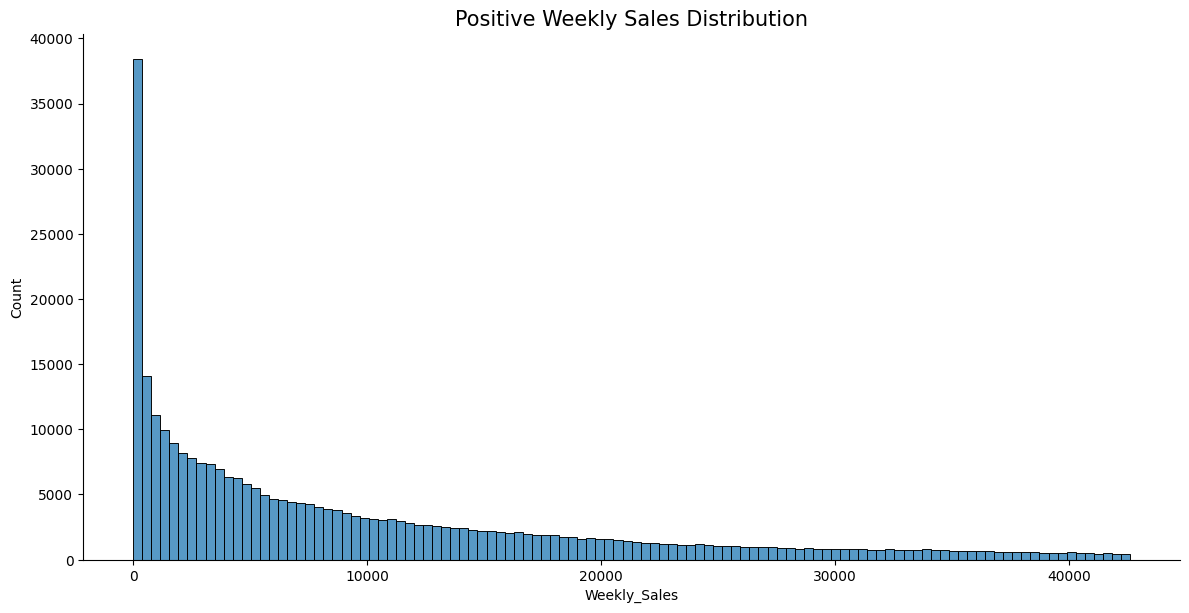

In [55]:
y_pd = data.select("Weekly_Sales").toPandas()["Weekly_Sales"]

# Filter out negative values
y_positive = y_pd[y_pd >= 0]

# Plot the distribution using Seaborn
sns.displot(y_positive, height=6, aspect=2)
plt.title("Positive Weekly Sales Distribution", fontsize=15)
plt.show()


In [56]:
# removing the negative weekly sales
data = data.filter(col('Weekly_Sales') >= 0)

In [57]:
# Get the shape of the filtered DataFrame
num_rows = data.count()
num_cols = len(data.columns)
print(num_rows,num_cols)

300700 20


In [58]:
data = data.withColumn("IsHoliday", col("IsHoliday").cast("int"))

In [59]:
data.show(5)

+-----+----+----------+------------+----+------+-----------+----------+-----------+------------+---------+--------------+----+-----+----+---------+---------+------------------+------------+-----------------+
|Store|Dept|      Date|Weekly_Sales|Type|  Size|Temperature|Fuel_Price|        CPI|Unemployment|IsHoliday|Total_MarkDown|Year|Month|Week|max_sales|min_sales|        mean_sales|median_sales|        std_sales|
+-----+----+----------+------------+----+------+-----------+----------+-----------+------------+---------+--------------+----+-----+----+---------+---------+------------------+------------+-----------------+
|    1|   1|2010-02-05|     24924.5|   A|151315|      42.31|     2.572|211.0963582|       8.106|        0|           0.0|2010|    2|   5| 57592.12| 14537.37|22513.322937062938|    18535.48|9854.349032299468|
|    1|   1|2010-02-19|    41595.55|   A|151315|      39.93|     2.514|211.2891429|       8.106|        0|           0.0|2010|    2|   7| 57592.12| 14537.37|22513.32293

In [60]:
file_path = '/content/drive/MyDrive/Cloud Computing Project Datasets/preprocessed_walmart_dataset.csv'

# Check if the file already exists
if os.path.exists(file_path):
    print("The file already exists.")
else:
    # Write the DataFrame to CSV
    data.write.csv(file_path, header=True)
    print("CSV file created successfully.")


The file already exists.


# **Data Visuallizations**

**Average Monthly Sales**

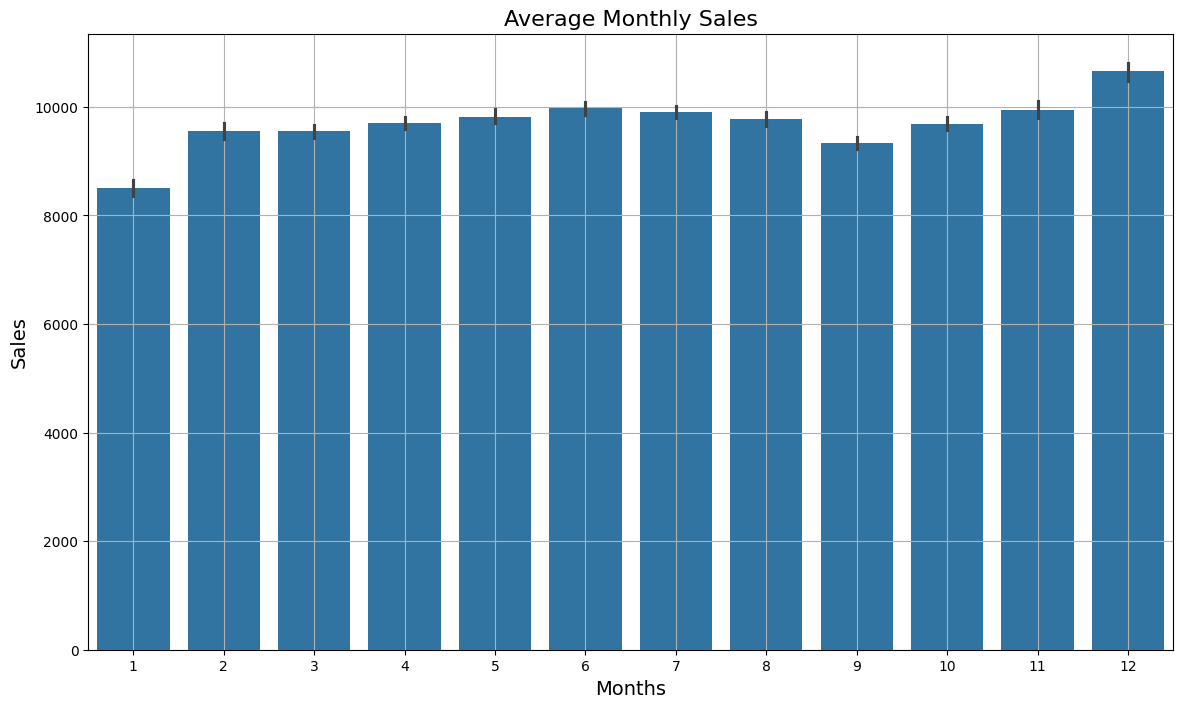

In [61]:
data = data.toPandas()

os.makedirs('plots', exist_ok=True)

plt.figure(figsize=(14,8))
sns.barplot(x='Month',y='Weekly_Sales',data=data)
plt.ylabel('Sales',fontsize=14)
plt.xlabel('Months',fontsize=14)
plt.title('Average Monthly Sales',fontsize=16)
plt.savefig('plots/avg_monthly_sales.png')
plt.grid()

In [62]:
data.head()

,Store,Dept,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Total_MarkDown,Year,Month,Week,max_sales,min_sales,mean_sales,median_sales,std_sales
0,1,1,2010-02-05,24924.50,A,151315,42.31,2.572,211.096358,8.106,0,0.0,2010,2,5,57592.12,14537.37,22513.322937,18535.48,9854.349032
1,1,1,2010-02-19,41595.55,A,151315,39.93,2.514,211.289143,8.106,0,0.0,2010,2,7,57592.12,14537.37,22513.322937,18535.48,9854.349032
2,1,1,2010-02-26,19403.54,A,151315,46.63,2.561,211.319643,8.106,0,0.0,2010,2,8,57592.12,14537.37,22513.322937,18535.48,9854.349032
3,1,1,2010-03-05,21827.90,A,151315,46.50,2.625,211.350143,8.106,0,0.0,2010,3,9,57592.12,14537.37,22513.322937,18535.48,9854.349032
4,1,1,2010-03-12,21043.39,A,151315,57.79,2.667,211.380643,8.106,0,0.0,2010,3,10,57592.12,14537.37,22513.322937,18535.48,9854.349032


**Monthly Sales for Each Year**

In [63]:
data_monthly = pd.crosstab(data["Year"], data["Month"], values=data["Weekly_Sales"],aggfunc='sum')
data_monthly

Month,1,2,3,4,5,6,7,8,9,10,11,12
Year,,,,,,,,,,,,
2010,NaN,98639119.48,97788130.30,1.233546e+08,1.004379e+08,1.007197e+08,1.256197e+08,1.008760e+08,9.728078e+07,1.222239e+08,1.018937e+08,1.294805e+08
2011,88195483.29,96096314.82,96015959.28,1.231256e+08,9.941399e+07,9.997057e+07,1.237299e+08,9.879127e+07,1.193720e+08,9.822554e+07,4.913290e+07,6.872789e+07
2012,47864921.91,10656461.35,72328192.37,5.638726e+07,5.099359e+07,7.136382e+07,6.035807e+07,5.639476e+07,5.044072e+07,8.416935e+07,NaN,NaN


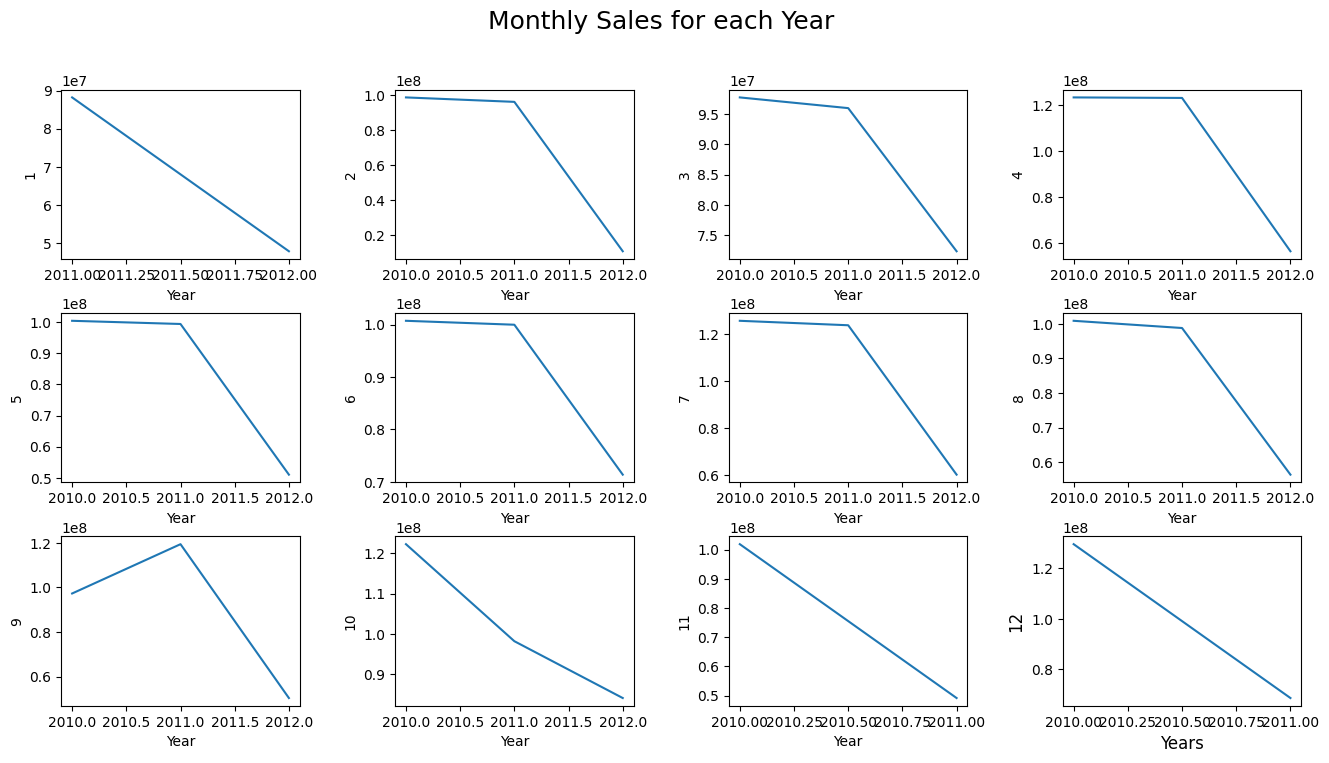

In [64]:
fig, axes = plt.subplots(3,4,figsize=(16,8))
plt.suptitle('Monthly Sales for each Year', fontsize=18)
k=1
for i in range(3):
    for j in range(4):
      sns.lineplot(ax=axes[i,j],data=data_monthly[k])
      plt.subplots_adjust(wspace=0.4,hspace=0.32)
      plt.ylabel(k,fontsize=12)
      plt.xlabel('Years',fontsize=12)
      k+=1

plt.savefig('plots/monthly_sales_every_year.png')
plt.show()

**Average Weekly Sales Store wise**

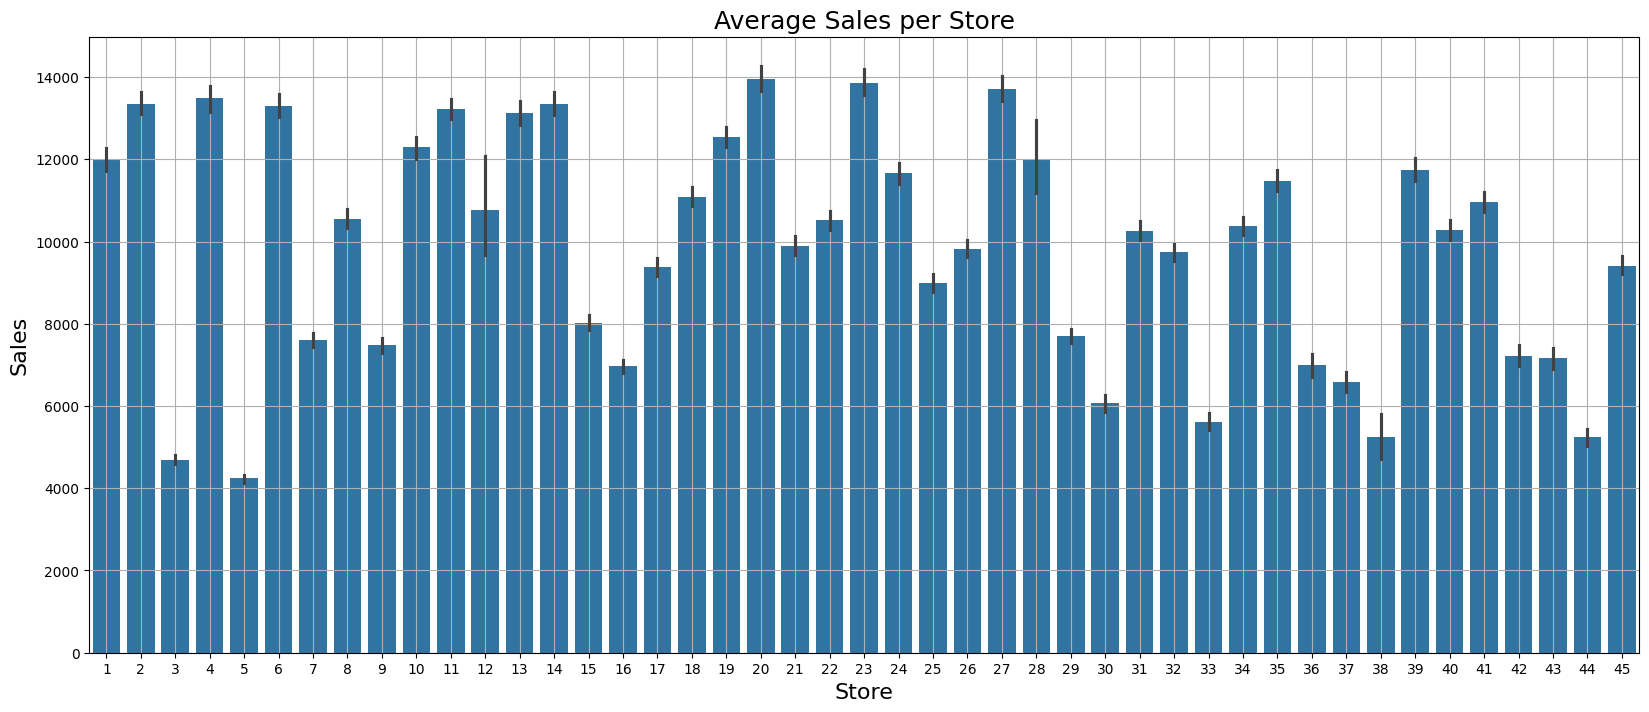

In [65]:
plt.figure(figsize=(20,8))
sns.barplot(x='Store',y='Weekly_Sales',data=data)
plt.grid()
plt.title('Average Sales per Store', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Store', fontsize=16)
plt.savefig('plots/avg_sales_store.png')
plt.show()

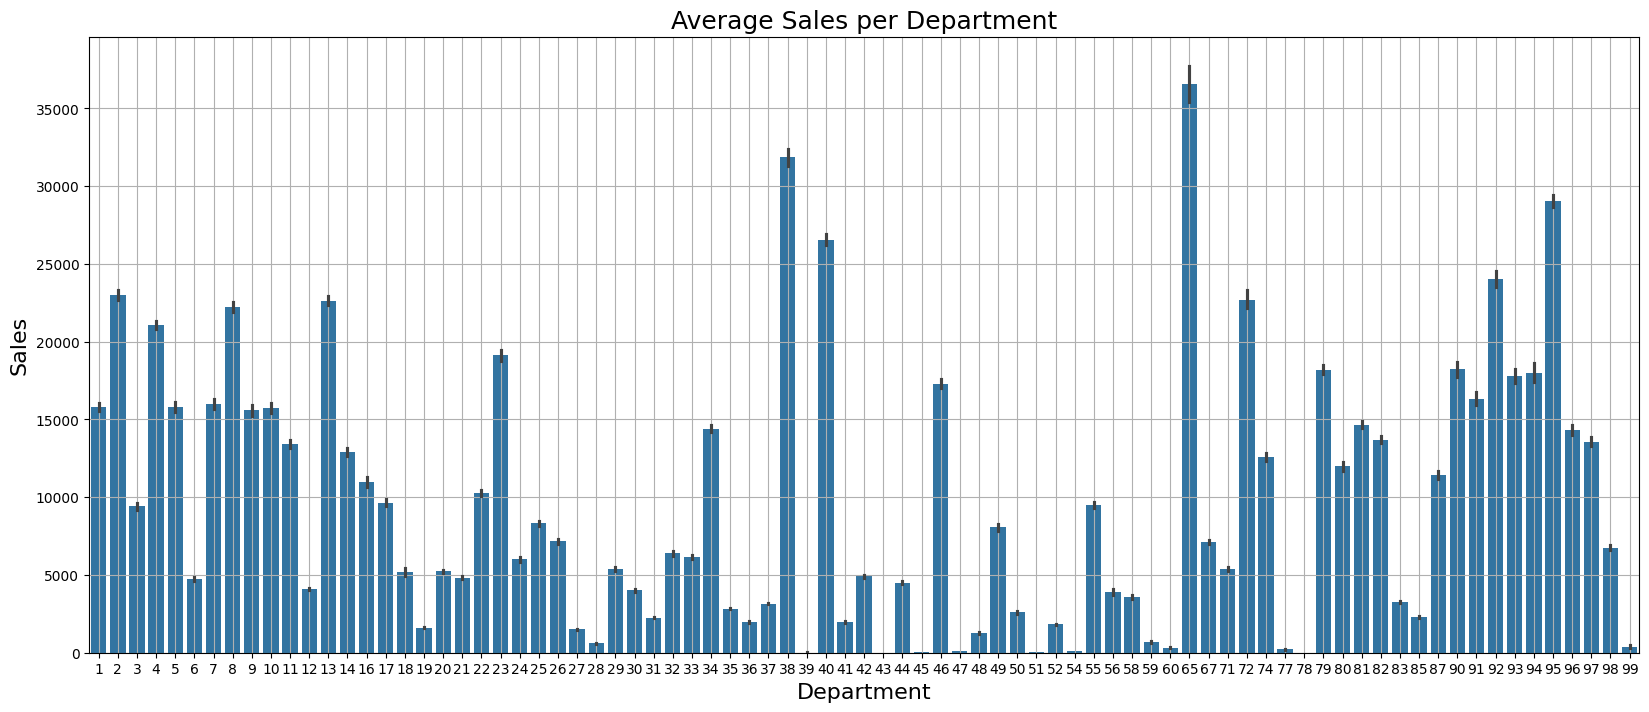

In [66]:
plt.figure(figsize=(20,8))
sns.barplot(x='Dept',y='Weekly_Sales',data=data)
plt.grid()
plt.title('Average Sales per Department', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Department', fontsize=16)
plt.savefig('plots/avg_sales_dept.png')
plt.show()

**Sales Vs Temperature**

<ipython-input-67-632529051a9b>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['Temperature'])


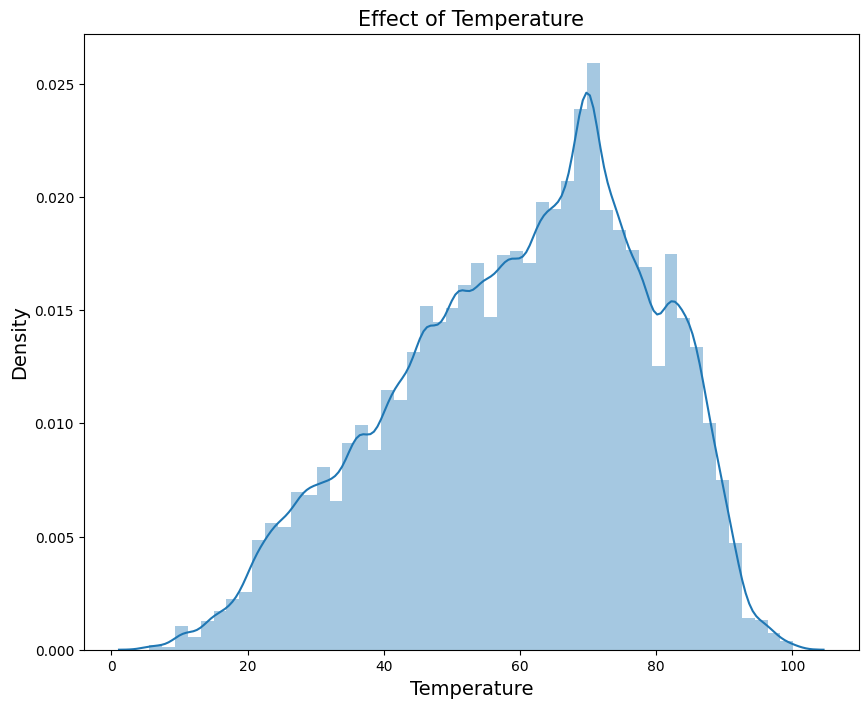

In [67]:
plt.figure(figsize=(10,8))
sns.distplot(data['Temperature'])
plt.title('Effect of Temperature',fontsize=15)
plt.xlabel('Temperature',fontsize=14)
plt.ylabel('Density',fontsize=14)
plt.savefig('plots/effect_of_temp.png')
plt.show()

**Holiday Distribution**

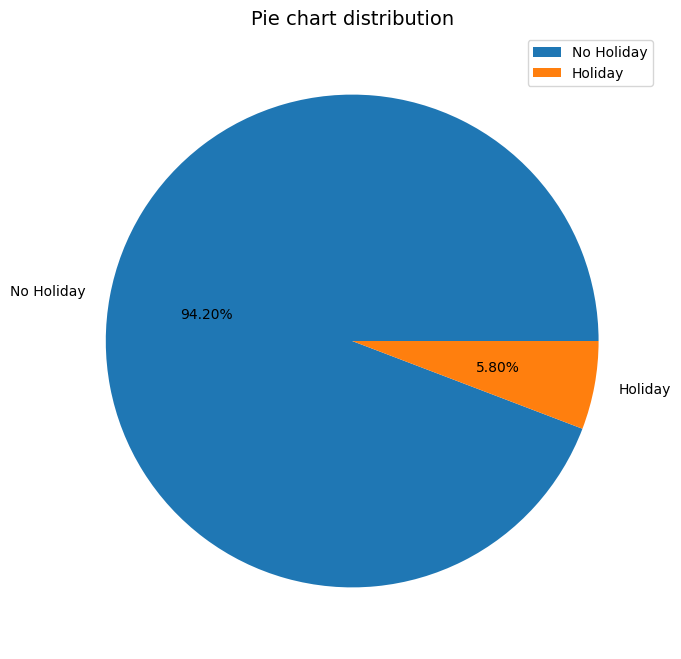

In [68]:
plt.figure(figsize=(8,8))
plt.pie(data['IsHoliday'].value_counts(),labels=['No Holiday','Holiday'],autopct='%0.2f%%')
plt.title("Pie chart distribution",fontsize=14)
plt.legend()
plt.savefig('plots/holiday_distribution.png')
plt.show()

## Time Series Decompose

In [69]:
data['Date'] = pd.to_datetime(data['Date'])

# Setting 'Date' column as index
data.set_index('Date', inplace=True)

In [70]:
data.head()

,Store,Dept,Weekly_Sales,Type,Size,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Total_MarkDown,Year,Month,Week,max_sales,min_sales,mean_sales,median_sales,std_sales
Date,,,,,,,,,,,,,,,,,,,
2010-02-05,1,1,24924.50,A,151315,42.31,2.572,211.096358,8.106,0,0.0,2010,2,5,57592.12,14537.37,22513.322937,18535.48,9854.349032
2010-02-19,1,1,41595.55,A,151315,39.93,2.514,211.289143,8.106,0,0.0,2010,2,7,57592.12,14537.37,22513.322937,18535.48,9854.349032
2010-02-26,1,1,19403.54,A,151315,46.63,2.561,211.319643,8.106,0,0.0,2010,2,8,57592.12,14537.37,22513.322937,18535.48,9854.349032
2010-03-05,1,1,21827.90,A,151315,46.50,2.625,211.350143,8.106,0,0.0,2010,3,9,57592.12,14537.37,22513.322937,18535.48,9854.349032
2010-03-12,1,1,21043.39,A,151315,57.79,2.667,211.380643,8.106,0,0.0,2010,3,10,57592.12,14537.37,22513.322937,18535.48,9854.349032


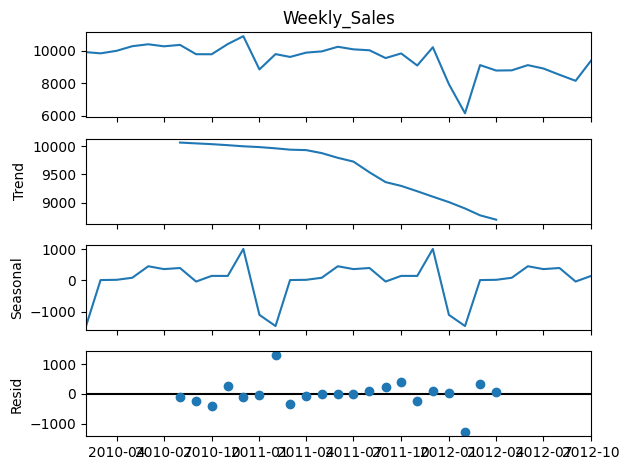

In [71]:
# Resample 'Weekly_Sales' column by month and take the mean
weekly_sales_resampled = data['Weekly_Sales'].resample('MS').mean()

# Perform seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(weekly_sales_resampled, model='additive')

# Plot the decomposition
decomposition.plot()
plt.savefig('plots/seasonal_decompose.png')
plt.show()


# **Feature Engineering**




## One-hot-encoding

In [72]:
# Extracting the Categorical columns
cat_col = ['Store','Dept','Type']
data_cat = data[cat_col].copy()

In [73]:
data_cat.tail()

,Store,Dept,Type
Date,,,
2012-10-05,45,93,B
2012-10-12,45,93,B
2012-10-19,45,93,B
2012-10-26,45,93,B
2012-03-16,45,96,B


In [74]:
# Creating the dummy columns for the categorical columns
data_cat = pd.get_dummies(data_cat,columns=cat_col)

In [75]:
data_cat.head()

,Store_1,Store_2,Store_3,Store_4,Store_5,Store_6,Store_7,Store_8,Store_9,Store_10,...,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99,Type_A,Type_B,Type_C
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2010-02-19,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2010-02-26,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2010-03-05,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2010-03-12,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [76]:
# Concating the categorical dummy columns to the original data
data = pd.concat([data, data_cat],axis=1)

In [77]:
data.shape

(300700, 148)

In [78]:
data.drop(columns=cat_col,inplace=True)

In [79]:
data.shape

(300700, 145)

## Data Normalization

In [80]:
data.columns

Index(['Weekly_Sales', 'Size', 'Temperature', 'Fuel_Price', 'CPI',
       'Unemployment', 'IsHoliday', 'Total_MarkDown', 'Year', 'Month',
       ...
       'Dept_93', 'Dept_94', 'Dept_95', 'Dept_96', 'Dept_97', 'Dept_98',
       'Dept_99', 'Type_A', 'Type_B', 'Type_C'],
      dtype='object', length=145)

In [81]:
num_col = ['Weekly_Sales','Size','Temperature','Fuel_Price','CPI','Unemployment','Total_MarkDown','max_sales','min_sales','median_sales','std_sales','mean_sales',]

In [82]:
# Normalizing the numerical columns
from sklearn.preprocessing import MinMaxScaler

minmax_scale = MinMaxScaler(feature_range=(0, 1))
def normalization(df,col):
  for i in col:
    arr = df[i]
    arr = np.array(arr)
    df[i] = minmax_scale.fit_transform(arr.reshape(len(arr),1))
  return df

In [83]:
data.head()

,Weekly_Sales,Size,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Total_MarkDown,Year,Month,...,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99,Type_A,Type_B,Type_C
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,24924.50,151315,42.31,2.572,211.096358,8.106,0,0.0,2010,2,...,False,False,False,False,False,False,False,True,False,False
2010-02-19,41595.55,151315,39.93,2.514,211.289143,8.106,0,0.0,2010,2,...,False,False,False,False,False,False,False,True,False,False
2010-02-26,19403.54,151315,46.63,2.561,211.319643,8.106,0,0.0,2010,2,...,False,False,False,False,False,False,False,True,False,False
2010-03-05,21827.90,151315,46.50,2.625,211.350143,8.106,0,0.0,2010,3,...,False,False,False,False,False,False,False,True,False,False
2010-03-12,21043.39,151315,57.79,2.667,211.380643,8.106,0,0.0,2010,3,...,False,False,False,False,False,False,False,True,False,False


In [84]:
data = normalization(data.copy(),num_col)

In [85]:
data.head()

,Weekly_Sales,Size,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Total_MarkDown,Year,Month,...,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99,Type_A,Type_B,Type_C
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,0.584809,0.630267,0.388689,0.050100,0.840500,0.566554,0,0.0,2010,2,...,False,False,False,False,False,False,False,True,False,False
2010-02-19,0.975966,0.630267,0.363531,0.021042,0.842405,0.566554,0,0.0,2010,2,...,False,False,False,False,False,False,False,True,False,False
2010-02-26,0.455270,0.630267,0.434355,0.044589,0.842707,0.566554,0,0.0,2010,2,...,False,False,False,False,False,False,False,True,False,False
2010-03-05,0.512153,0.630267,0.432981,0.076653,0.843008,0.566554,0,0.0,2010,3,...,False,False,False,False,False,False,False,True,False,False
2010-03-12,0.493746,0.630267,0.552326,0.097695,0.843310,0.566554,0,0.0,2010,3,...,False,False,False,False,False,False,False,True,False,False


## Correlation between features of dataset

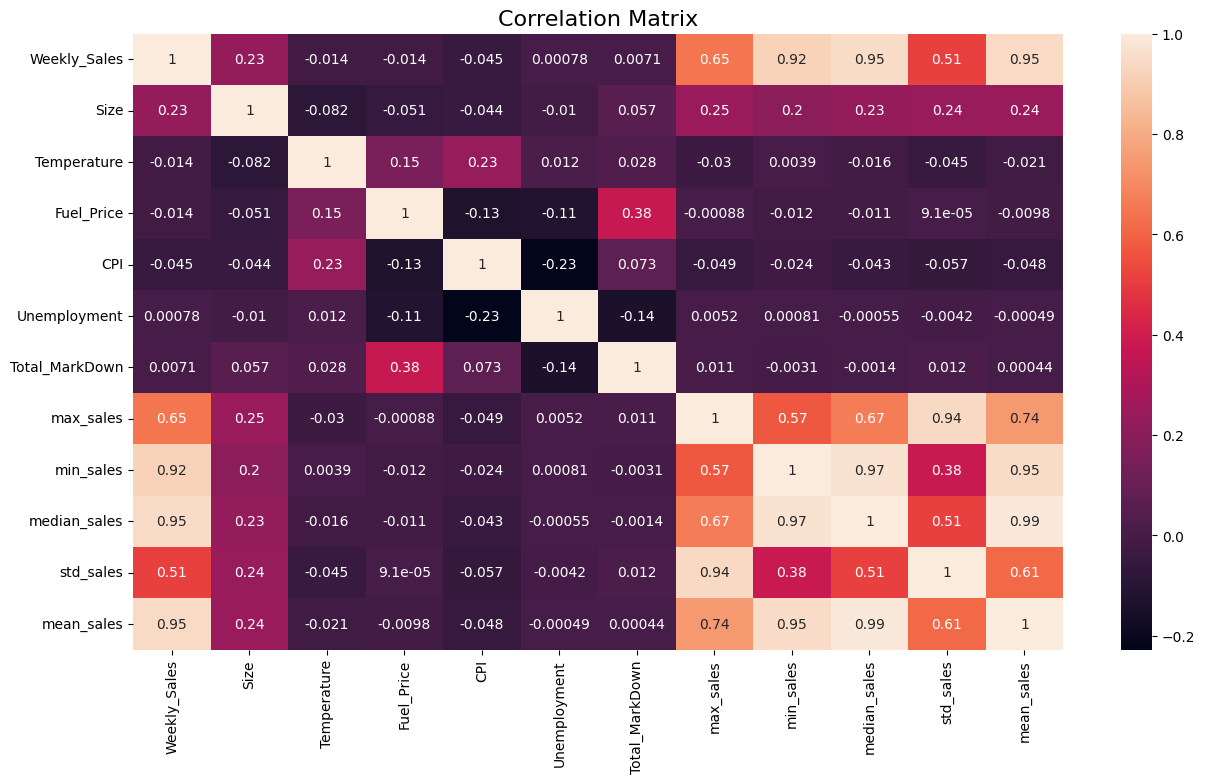

In [86]:
plt.figure(figsize=(15,8))
corr = data[num_col].corr()
sns.heatmap(corr,vmax=1.0,annot=True)
plt.title('Correlation Matrix',fontsize=16)
plt.savefig('plots/correlation_matrix.png')
plt.show()

## Recursive Feature Elimination

In [87]:
feature_col = data.columns.difference(['Weekly_Sales'])
feature_col

Index(['CPI', 'Dept_1', 'Dept_10', 'Dept_11', 'Dept_12', 'Dept_13', 'Dept_14',
       'Dept_16', 'Dept_17', 'Dept_18',
       ...
       'Type_B', 'Type_C', 'Unemployment', 'Week', 'Year', 'max_sales',
       'mean_sales', 'median_sales', 'min_sales', 'std_sales'],
      dtype='object', length=144)

We are finding the importance of features for the target variable 'Weekly Sales'

In [88]:
radm_clf = RandomForestRegressor(oob_score=True,n_estimators=23)
radm_clf.fit(data[feature_col], data['Weekly_Sales'])

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


RandomForestRegressor(n_estimators=23, oob_score=True)

In [89]:
import os
import pickle

# Specify the directory and file path
directory = './models/'
os.makedirs(directory, exist_ok=True)
pkl_filename = os.path.join(directory, 'feature_elim_regressor.pkl')

# Save the trained model to disk
with open(pkl_filename, 'wb') as file:
    pickle.dump(radm_clf, file)
print("Saved model to disk")

Saved model to disk


In [90]:
indices = np.argsort(radm_clf.feature_importances_)[::-1]
feature_rank = pd.DataFrame(columns = ['rank', 'feature', 'importance'])

for f in range(data[feature_col].shape[1]):
    feature_rank.loc[f] = [f+1,
                           data[feature_col].columns[indices[f]],
                           radm_clf.feature_importances_[indices[f]]]

feature_rank

,rank,feature,importance
0,1,mean_sales,7.736881e-01
1,2,median_sales,1.407097e-01
2,3,Week,2.402826e-02
3,4,Temperature,1.103677e-02
4,5,CPI,7.052564e-03
...,...,...,...
139,140,Dept_51,7.650991e-10
140,141,Dept_45,7.100358e-10
141,142,Dept_78,1.858140e-11
142,143,Dept_39,6.781391e-14


We are printing the columns that has higher impact of weekly sales

In [91]:
x=feature_rank.loc[0:22,['feature']]
x=x['feature'].tolist()
print(x)

['mean_sales', 'median_sales', 'Week', 'Temperature', 'CPI', 'Fuel_Price', 'min_sales', 'max_sales', 'Unemployment', 'std_sales', 'Month', 'Dept_16', 'Total_MarkDown', 'Size', 'Dept_3', 'Dept_18', 'IsHoliday', 'Dept_9', 'Dept_56', 'Dept_1', 'Year', 'Dept_55', 'Dept_11']


In [92]:
data.head(2)

,Weekly_Sales,Size,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Total_MarkDown,Year,Month,...,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99,Type_A,Type_B,Type_C
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,0.584809,0.630267,0.388689,0.050100,0.840500,0.566554,0,0.0,2010,2,...,False,False,False,False,False,False,False,True,False,False
2010-02-19,0.975966,0.630267,0.363531,0.021042,0.842405,0.566554,0,0.0,2010,2,...,False,False,False,False,False,False,False,True,False,False


In [93]:
# Reset the index to drop the date index (since we created seperate columns for day, month and year)
data = data.reset_index(drop=True)

In [94]:
data.head(2)

,Weekly_Sales,Size,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Total_MarkDown,Year,Month,...,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99,Type_A,Type_B,Type_C
0,0.584809,0.630267,0.388689,0.050100,0.840500,0.566554,0,0.0,2010,2,...,False,False,False,False,False,False,False,True,False,False
1,0.975966,0.630267,0.363531,0.021042,0.842405,0.566554,0,0.0,2010,2,...,False,False,False,False,False,False,False,True,False,False


In [95]:
column_dtypes = data.dtypes

print(column_dtypes)

Weekly_Sales    float64
Size            float64
Temperature     float64
Fuel_Price      float64
CPI             float64
                 ...   
Dept_98            bool
Dept_99            bool
Type_A             bool
Type_B             bool
Type_C             bool
Length: 145, dtype: object


In [96]:
data_pd=data

In [97]:
os.makedirs('datasets', exist_ok=True)
data.to_csv('datasets/Final_data_spark.csv')

Creating the spark dataframe from the Final dataset

In [98]:
rows = []
for _, row in data.iterrows():
    rows.append(Row(**row))

spark_df = spark.createDataFrame(rows)
spark_df.show()


+-------------------+------------------+-------------------+--------------------+------------------+------------------+---------+--------------+----+-----+----+-------------------+-------------------+------------------+-------------------+-------------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--

# **Machine Learning Model Building**






Preparing the data

In [99]:
# Defining the  feature columns (all columns except 'Weekly_Sales')
feature_columns = [col for col in spark_df.columns if col != 'Weekly_Sales']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

#  VectorAssembler Method
data = assembler.transform(spark_df)

# Splited the data into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=50)

# Select the features vector and the target variable for training
train_data = train_data.select("features", col("Weekly_Sales").alias("label"))
test_data = test_data.select("features", col("Weekly_Sales").alias("label"))

## Linear Regression model

In [125]:
# Initialize and fit the LinearRegression model
lr = LinearRegression(featuresCol='features', labelCol='label')
lr_model = lr.fit(train_data)

predictions = lr_model.transform(test_data)

evaluator_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

# Print evaluation metrics
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R2 Score:", r2)

Root Mean Squared Error (RMSE): 0.07314793780694373
Mean Absolute Error (MAE): 0.04066343300526707
R2 Score: 0.9086087655372088


In [126]:
lr_acc= evaluator_r2.evaluate(predictions)*100
print("Performance of Linear Regressor:", lr_acc)


Performance of Linear Regressor: 90.86087655372089


In [127]:
model_path = "./models/linear_regression"

# Check if the model directory exists
if not os.path.exists(model_path):
    # Save the trained model to disk
    lr_model.save(model_path)
    print("Saved model to disk")
else:
    print("Model already saved")

Model already saved


## Random Forest Regressor Model

In [128]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

rf = RandomForestRegressor(featuresCol='features', labelCol='label')
rf_model = rf.fit(train_data)

# Make predictions on the test data
predictions = rf_model.transform(test_data)
# Evaluate the model
evaluator_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print("(R2) Score:", r2)
print("MAE:", mae)
print("RMSE:", rmse)

(R2) Score: 0.9123813826734217
MAE: 0.039577542363632666
RMSE: 0.07162225869780668


In [129]:
rf_acc = evaluator_r2.evaluate(predictions)*100
print("Performance of Random Forest Accuracy:",rf_acc)


Performance of Random Forest Accuracy: 91.23813826734218


In [130]:
model_path = "./models/randomforest_regressor"

if not os.path.exists(model_path):
    rf_model.save(model_path)
    print("Saved model to disk")
else:
    print("Model already saved")


Model already saved


## Decision Tree Regression

In [131]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

dt = DecisionTreeRegressor(featuresCol='features', labelCol='label')
dt_model = dt.fit(train_data)

# Making the predictions on the test data
predictions = dt_model.transform(test_data)

# Evaluating the model
evaluator_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print(" (R2):", r2)
print("MAE:", mae)
print("RMSE:", rmse)

 (R2): 0.910081344766975
MAE: 0.040049165713995506
RMSE: 0.07255623133129478


In [132]:
dt_acc = evaluator_r2.evaluate(predictions)*100
print("Performance of Decision Tree Model:", dt_acc)

Performance of Decision Tree Model: 91.0081344766975


In [133]:
model_path = "./models/DecisionTree_regressor"

if not os.path.exists(model_path):
    dt_model.save(model_path)
    print("Saved model to disk")
else:
    print("Model already saved")

Model already saved


<br>

## Gradient Boost Regression model

In [134]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

gbt = GBTRegressor(featuresCol='features', labelCol='label')
gbt_model = gbt.fit(train_data)
predictions = gbt_model.transform(test_data)

# Evaluating the model
evaluator_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print(" (R2):", r2*100)
print("MAE:", mae)
print("RMSE:", rmse)


 (R2): 93.52669530710426
MAE: 0.035696445749745134
RMSE: 0.061562016910686516


In [135]:
gb_acc = evaluator_r2.evaluate(predictions)*100
print("Performance of Gradient Boost Model:", gb_acc)

Performance of Gradient Boost Model: 93.52669530710426


In [136]:
model_path = "./models/gradientboost_regressor"

if not os.path.exists(model_path):
    gbt_model.save(model_path)
    print("Saved model to disk")
else:
    print("Model already saved")

Model already saved


## Customised deep neural network

In [148]:
X = data_pd[feature_col]
Y = data_pd['Weekly_Sales']

X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.20, random_state=50)

In [149]:
def create_model():
  model = Sequential()
  model.add(Dense(64, input_dim=X_train.shape[1], kernel_initializer='normal',activation='relu'))
  model.add(Dense(32, kernel_initializer='normal'))
  model.add(Dense(1, kernel_initializer='normal'))
  model.compile(loss='mean_absolute_error', optimizer='adam')
  return model

In [150]:
estimator_model = KerasRegressor(build_fn=create_model, verbose=1)
model = create_model()

# Train the model and record the history
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=5000, verbose=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 2.0553 - val_loss: 0.3462
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2945 - val_loss: 0.2100
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1841 - val_loss: 0.1707
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1675 - val_loss: 0.2194
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2122 - val_loss: 0.1500
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1724 - val_loss: 0.2198
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1964 - val_loss: 0.1432
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1812 - val_loss: 0.1615
Epoch 9/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1876 - val_loss: 0.2553
Epoch 10/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2675 - val_loss: 0.4280
Epoch 11/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3579 - val_loss: 0.1232
Epoch 12/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

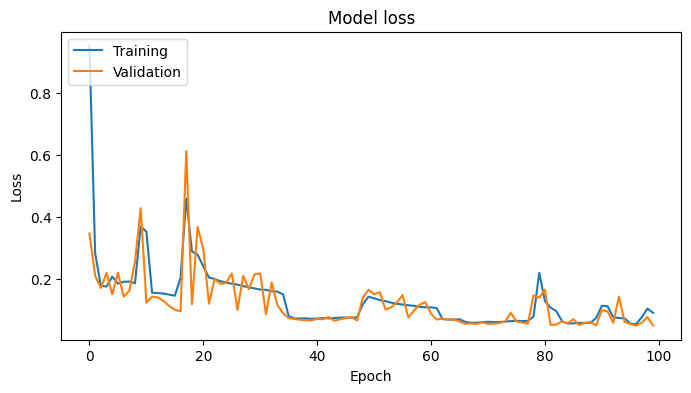

In [151]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

plt.savefig('plots/dnn_loss.png')
plt.show()

In [152]:
y_pred = model.predict(X_test)
print("MAE" , metrics.mean_absolute_error(y_test, y_pred))
print("MSE" , metrics.mean_squared_error(y_test, y_pred))
print("RMSE" , np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("R2" , metrics.explained_variance_score(y_test, y_pred))

1880/1880 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
MAE 0.05009925648635491
MSE 0.006934203723916599
RMSE 0.0832718663410194
R2 0.8829941394178967


In [153]:
dnn_acc = metrics.r2_score(y_pred, y_test)*100
print("Performance of Deep Neural Network - ",dnn_acc)

Performance of Deep Neural Network -  84.5137740806417


# **Performance of Models**

In [154]:
acc = {'model':['lr_acc','rf_acc','dt_acc','gb_acc','dnn_acc'],'accuracy':[lr_acc,rf_acc,dt_acc,gb_acc,dnn_acc]}

In [155]:
acc_df = pd.DataFrame(acc)
acc_df

,model,accuracy
0,lr_acc,90.860877
1,rf_acc,91.238138
2,dt_acc,91.008134
3,gb_acc,93.526695
4,dnn_acc,84.513774


<ipython-input-156-7ba98961c1ae>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y='accuracy', data=acc_df, palette=colors)


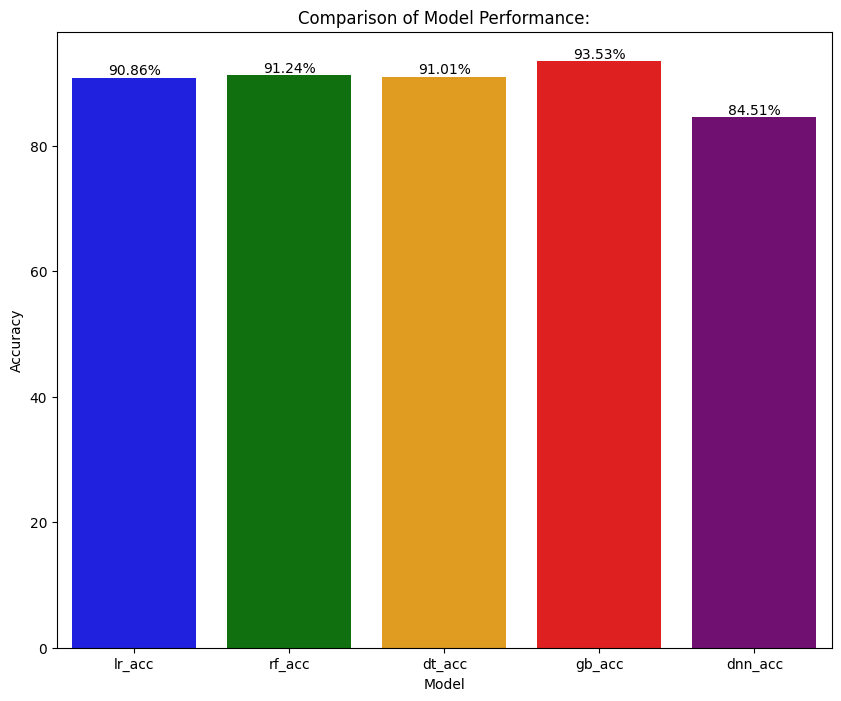

In [156]:
colors = ['blue', 'green', 'orange', 'red', 'purple']

plt.figure(figsize=(10, 8))
sns.barplot(x='model', y='accuracy', data=acc_df, palette=colors)

# Adding percentage text on bars
for idx, val in enumerate(acc_df['accuracy']):
    plt.text(idx, val, f'{val:.2f}%', ha='center', va='bottom')

plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Performance:')
plt.savefig('plots/compared_models.png')
plt.show()
